In [2]:
import tensorflow as tf
from keras import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.utils import to_categorical
import os
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
from sklearn.model_selection import train_test_split


In [4]:
def load_images_from_folder(folder,only_path = False, label = ""):
# Load the paths to the images in a directory
# or load the images
    if only_path == False:
        images = []
        for filename in os.listdir(folder):
            img = plt.imread(os.path.join(folder,filename))
            if img is not None:
                images.append(img)
        return images
    else:
        path = []
        for filename in os.listdir(folder):
            img_path = os.path.join(folder,filename)
            if img_path is not None:
                path.append([label,img_path])
        return path

In [5]:
images = []
dirp = "fruit_reco_dataset/train/"
for f in os.listdir(dirp):
    if "jpg" in os.listdir(dirp+f)[0]:
        images += load_images_from_folder(dirp+f,True,label = f)
    else:
        for d in os.listdir(dirp+f):
            images += load_images_from_folder(dirp+f+"/"+d,True,label = f)
test_list = []
test = "fruit_reco_dataset/test/"
for f in os.listdir(dirp):
    if "jpg" in os.listdir(dirp+f)[0]:
        test_list += load_images_from_folder(dirp+f,True,label = f)
    else:
        for d in os.listdir(dirp+f):
            test_list += load_images_from_folder(dirp+f+"/"+d,True,label = f)

# Create a dataframe with the paths and the label for each fruit

df = pd.DataFrame(images, columns = ["fruit", "path"])

l = []
for i in df['path'].values:
    i = i.replace("\\","/")
    l.append(i)

df["path"] = l

print(df.head())

   fruit                                         path
0  Apple   fruit_reco_dataset/train/Apple/apple_1.jpg
1  Apple  fruit_reco_dataset/train/Apple/apple_10.jpg
2  Apple  fruit_reco_dataset/train/Apple/apple_11.jpg
3  Apple  fruit_reco_dataset/train/Apple/apple_12.jpg
4  Apple  fruit_reco_dataset/train/Apple/apple_13.jpg


In [6]:
fruit_names = sorted(df.fruit.unique())
mapper_fruit_names = dict(zip(fruit_names, [t for t in range(len(fruit_names))]))
df["label"] = df["fruit"].map(mapper_fruit_names)
print(mapper_fruit_names)

{'Apple': 0, 'Banana': 1, 'Mixed': 2, 'Orange': 3}


In [48]:
def load_img(df):
    img_paths = df["path"].values
    img_labels = df["label"].values
    X = []
    y = []
    z = []

    for i,path in enumerate(img_paths):
        img = plt.imread(path)
        gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray_image = cv2.resize(gray_image, (150,150))
        label = img_labels[i]
        X.append(gray_image)
        y.append(label)
        z.append(img_paths[i])
    return np.array(X),np.array(y), np.array(z)

In [8]:
def create_model():
    shape_img = (150,150,1)

    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(len(mapper_fruit_names)))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

    return model

In [9]:
def cut_df(df, number_of_parts, part):

    if part < 1:
        print("Error, the part should be at least 1")
    elif part > number_of_parts:
        print("Error, the part cannot be higher than the number_of_parts")

    number_imgs_each_part = int(df.shape[0]/number_of_parts)
    idx1 = (part-1) * number_imgs_each_part
    idx2 = part * number_imgs_each_part
    return df.iloc[idx1:idx2]

In [13]:
model = create_model()
hists = []

X_train, y_train = load_img(df)
y_train = to_categorical(y_train)

model.fit(X_train, y_train, batch_size=128, epochs=50, validation_split = 0.1, verbose = 1)

Epoch 1/50
2/2 [==============================] - 12s 5s/step - loss: 532.2810 - accuracy: 0.2778 - val_loss: 2815.7773 - val_accuracy: 0.0000e+00
Epoch 2/50
2/2 [==============================] - 18s 12s/step - loss: 1008.3875 - accuracy: 0.3287 - val_loss: 521.8538 - val_accuracy: 0.0000e+00
Epoch 3/50
2/2 [==============================] - 7s 3s/step - loss: 221.7997 - accuracy: 0.1991 - val_loss: 70.9269 - val_accuracy: 0.0000e+00
Epoch 4/50
2/2 [==============================] - 8s 4s/step - loss: 43.8701 - accuracy: 0.4491 - val_loss: 35.4678 - val_accuracy: 0.0000e+00
Epoch 5/50
2/2 [==============================] - 6s 3s/step - loss: 24.6848 - accuracy: 0.3565 - val_loss: 1.4969 - val_accuracy: 0.5833
Epoch 6/50
2/2 [==============================] - 7s 3s/step - loss: 5.2875 - accuracy: 0.4907 - val_loss: 0.3469 - val_accuracy: 0.8750
Epoch 7/50
2/2 [==============================] - 7s 3s/step - loss: 2.5267 - accuracy: 0.5648 - val_loss: 0.7138 - val_accuracy: 0.7083
Epoch 

In [39]:
test_df = pd.DataFrame(test_list, columns = ["fruit", "path"])
test_df["label"] = test_df["fruit"].map(mapper_fruit_names)


l = []
for i in test_df['path'].values:
    i = i.replace("\\","/")
    l.append(i)

test_df["path"] = l
test_df.head(100)

,fruit,path,label
0,Apple,fruit_reco_dataset/train/Apple/apple_1.jpg,0
1,Apple,fruit_reco_dataset/train/Apple/apple_10.jpg,0
2,Apple,fruit_reco_dataset/train/Apple/apple_11.jpg,0
3,Apple,fruit_reco_dataset/train/Apple/apple_12.jpg,0
4,Apple,fruit_reco_dataset/train/Apple/apple_13.jpg,0
...,...,...,...
95,Banana,fruit_reco_dataset/train/Banana/banana_30.jpg,1
96,Banana,fruit_reco_dataset/train/Banana/banana_31.jpg,1
97,Banana,fruit_reco_dataset/train/Banana/banana_32.jpg,1
98,Banana,fruit_reco_dataset/train/Banana/banana_33.jpg,1


8/8 [==============================] - 2s 187ms/step


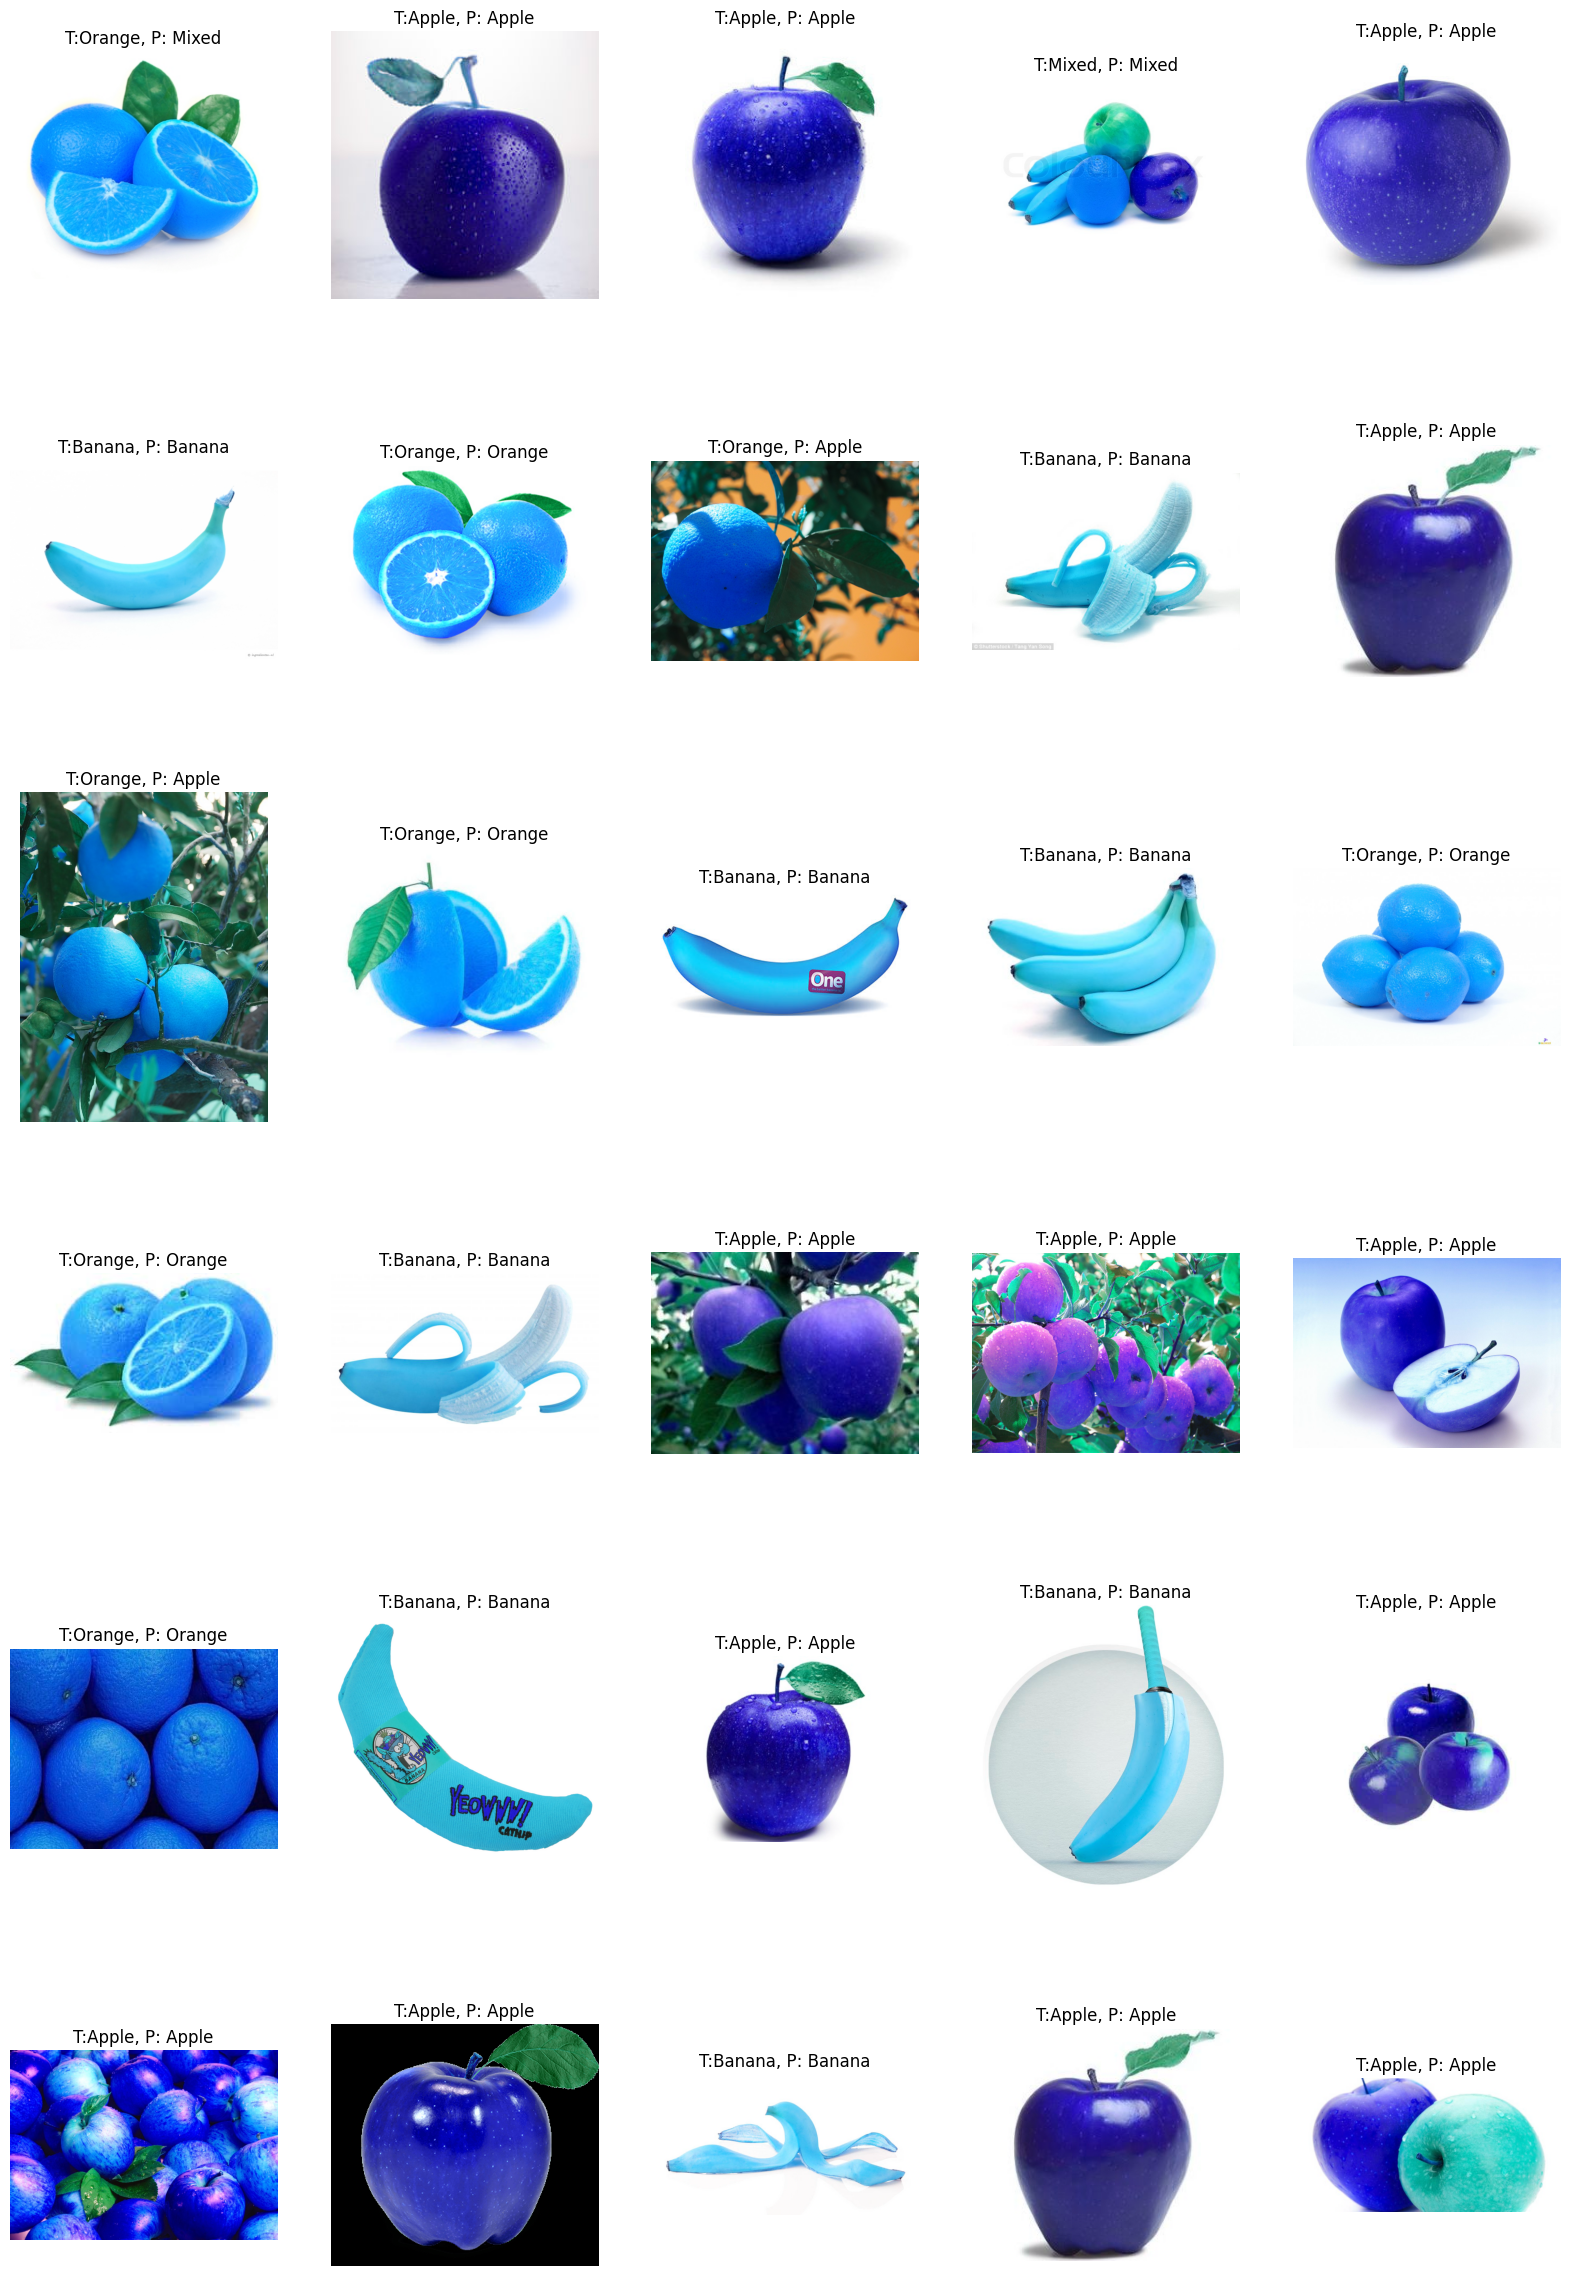

In [54]:
# train_df,test_df = train_test_split(test_df[['path','fruit']].sample(frac=0.05,random_state=0), test_size=0.2,random_state=0)
from matplotlib import pyplot as plt
import random

fig = plt.figure(figsize=(20, 30))

X, y, z = load_img(test_df)
pred = np.argmax(model.predict(X),axis=1)


for i in range(30):
    fig.add_subplot(6, 5, i+1)
    r = random.randint(0, len(y))
    plt.imshow(cv2.imread(z[r]))
    plt.axis('off')
    plt.title(f"T:{fruit_names[y[r]]}, P: {fruit_names[pred[r]]}")
    # print(f"T:{fruit_names[y[-i]]}, P: {fruit_names[pred[-i]]}")